# Neural & Behavioral Modeling - Week 15 (Exercises)
Howard Chao (ntueeb05howard@gmail.com)

In [1]:
# Upgrade PyTorch to 0.4.0 if necessary:
! conda install -y pytorch-cpu torchvision-cpu -c pytorch

Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - torchvision-cpu
  - pytorch-cpu

Current channels:

  - https://conda.anaconda.org/pytorch/osx-64
  - https://conda.anaconda.org/pytorch/noarch
  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/free/osx-64
  - https://repo.anaconda.com/pkgs/free/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/pro/osx-64
  - https://repo.anaconda.com/pkgs/pro/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [352]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d.axes3d import *
from IPython.display import *
import numpy as np

In [353]:
# PyTorch
import torch as t
import torch.utils.data as Data
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
from torchvision.datasets import CIFAR10
show = ToPILImage()

In [354]:
# Check GPU status:
import torch as t
t.manual_seed(1)    # for reproduction
print('PyTorch version:',t.__version__)
use_cuda=t.cuda.is_available()
if(use_cuda):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
    device = t.device("cuda")
else:
    device = t.device("cpu")
    print('No GPU')

PyTorch version: 0.4.0
No GPU


## 1 Visualizing the latent space of an autoencoder (7 points)

Please train an autoencoder to project MNIST (training) images to a 2D latent space and visualize how these images are organzed in the latent space, as demonstrated in P.9 of 15.pdf.

### 1.0 The MNIST Data

In [355]:
# Download the dataset:
import urllib.request
urllib.request.urlretrieve('http://deeplearning.net/data/mnist/mnist.pkl.gz','mnist.pkl.gz')

('mnist.pkl.gz', <http.client.HTTPMessage at 0x15d14eb38>)

In [449]:
train_data = tv.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=tv.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=True,                        # download it if you don't have it
)

In [450]:
train_loader = t.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

In [364]:
# # Load the dataset:
# import pickle, gzip
# f = gzip.open('mnist.pkl.gz','rb')
# train_set, valid_set, test_set = pickle.load(f,encoding='unicode-escape')
# train_data = t.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
# test_data = t.utils.data.DataLoader(train_set, batch_size=1000, shuffle=True)
# f.close()
# x_train,y_train=train_set[0],train_set[1]
# x_valid,y_valid=valid_set[0],valid_set[1]
# x_test,y_test=test_set[0],test_set[1]
# X_train=t.from_numpy(x_train)
# Y_train=t.from_numpy(y_train)
# X_test=t.from_numpy(x_test)
# Y_test=t.from_numpy(y_test)

In [366]:
# # Examine the dataset:
# print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
# print(np.min(x_train),np.max(x_train),np.min(y_train),np.max(y_train))
# for i in range(50):
#     subplot(5,10,i+1)
#     imshow(x_test[i].reshape([28,28]),cmap='gray');
#     title(str(y_test[i]));
#     axis('off')

### 1.1 An autoencoder

In [367]:
# Define the network:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
#             nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, 64),
#             nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Linear(64, 12),
#             nn.BatchNorm1d(12),
            nn.ReLU(True),
            nn.Linear(12, 2) # 2-dimensional latent space
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode

In [368]:
EPOCH = 3
BATCH_SIZE = 64
LR = 0.005
autoencoder = autoencoder()

In [369]:
optimizer = t.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

In [370]:
for epoch in range(EPOCH):
    running_loss = 0.0
    for step, (x, b_label) in enumerate(train_loader):
        b_x = x.view(-1, 28*28)   # batch x, shape (batch, 28*28)
        b_y = x.view(-1, 28*28)   # batch y, shape (batch, 28*28)
        
        encoded, decoded = autoencoder(b_x)
#         print(decoded.shape)
#         k = (decoded-b_y)[0]
#         print(k.detach().numpy())
#         print(np.sum((decoded-b_y)[0].detach().numpy()))
#         print(b_x.shape[0])
        loss = loss_func(decoded, b_y)      # mean square error
#         print(loss)
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
        running_loss += loss.item()
        if step % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, step + 1, running_loss / 100))
            running_loss = 0.0

[1,   100] loss: 0.065
[1,   200] loss: 0.057
[1,   300] loss: 0.054
[1,   400] loss: 0.052
[1,   500] loss: 0.051
[1,   600] loss: 0.049
[1,   700] loss: 0.048
[1,   800] loss: 0.048
[1,   900] loss: 0.048
[1,  1000] loss: 0.048
[1,  1100] loss: 0.046
[1,  1200] loss: 0.047
[1,  1300] loss: 0.046
[1,  1400] loss: 0.046
[1,  1500] loss: 0.046
[1,  1600] loss: 0.045
[1,  1700] loss: 0.045
[1,  1800] loss: 0.045
[2,   100] loss: 0.045
[2,   200] loss: 0.046
[2,   300] loss: 0.045
[2,   400] loss: 0.044
[2,   500] loss: 0.044
[2,   600] loss: 0.044
[2,   700] loss: 0.044
[2,   800] loss: 0.043
[2,   900] loss: 0.043
[2,  1000] loss: 0.043
[2,  1100] loss: 0.045
[2,  1200] loss: 0.043
[2,  1300] loss: 0.043
[2,  1400] loss: 0.043
[2,  1500] loss: 0.043
[2,  1600] loss: 0.043
[2,  1700] loss: 0.043
[2,  1800] loss: 0.042
[3,   100] loss: 0.042
[3,   200] loss: 0.042
[3,   300] loss: 0.042
[3,   400] loss: 0.043
[3,   500] loss: 0.042
[3,   600] loss: 0.042
[3,   700] loss: 0.042
[3,   800] 

(-5.7905631, 18.675114)

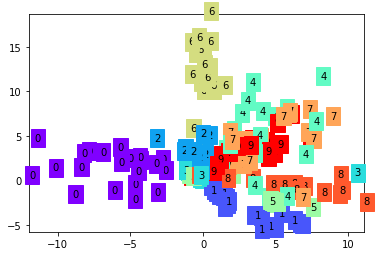

In [375]:
# 要观看的数据
view_data = train_data.train_data[:200].view(-1, 28*28).type(t.FloatTensor)/255.
encoded_data, output = autoencoder(view_data)    # 提取压缩的特征值
fig = figure(2)
ax = fig.gca()

X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()

values = train_data.train_labels[:200].numpy()  # 标签值
for x, y, s in zip(X, Y, values):
    c = cm.rainbow(int(255*s/9))    # 上色
    ax.text(x, y, s, backgroundcolor=c)  # 标位子
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())

In [376]:
output

tensor([[-9.5860e-04, -1.1515e-04, -1.7395e-04,  ...,  6.1328e-04,
          2.0699e-05, -2.3966e-03],
        [-2.6146e-03,  1.1770e-04,  1.8049e-04,  ..., -1.1961e-03,
         -2.0415e-04,  2.5728e-03],
        [ 5.9338e-04, -1.8927e-04, -6.2157e-05,  ..., -2.3963e-05,
         -2.2767e-05, -1.8547e-04],
        ...,
        [ 4.0010e-04, -2.9344e-04, -8.0920e-05,  ..., -3.0924e-04,
         -4.7813e-05,  1.2113e-03],
        [-2.7848e-03, -1.0935e-04, -6.3391e-05,  ...,  2.6099e-04,
         -6.4354e-05, -1.2782e-03],
        [-2.3570e-06, -2.9154e-04, -7.6791e-05,  ...,  1.8639e-04,
          4.1526e-06, -7.4034e-04]])

IndexError: index 1 is out of bounds for axis 0 with size 1

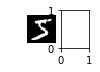

In [440]:
# Examine the dataset:
for i in range(50):
    subplot(5,10,i+1)
    imshow((train_data[0][0][0]).numpy()[i].reshape([28,28]),cmap='gray');
#     title(str(train_data[1][i]));
    axis('off')

### 1.2 Your visualization

In [ ]:
# Please run your analysis here

## 2 Integer Factorization (3 points)

Here we explore the possibilty that a neural network may be able to judge whether an input integer is a prime number or not.

* Computational problem: tell if an input is a prime number 

* Network Input: an integer in binary code (e.g., 0→000000000000000 (15 bits); 1→000000000000001; 2→000000000000010)

* Network Output: 1 unit (1=yes; 0=no)

* Network Architecture: your choice

* Data set: You can enlarge your training and testing data sets, if necessary. Training accuracies and testing accuraces are both informative but of course we care more about the testing ones.

### 2.1 The data set

In [31]:
from math import sqrt; from itertools import count, islice

def isPrime(n):
    return n > 1 and all(n%i for i in islice(count(2), int(sqrt(n)-1)))

ifPrime=np.vectorize(isPrime)    

x=np.arange(32768) #2^15
y=ifPrime(x).astype(int) 

# Training-testing splits:

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

# Training data:
print(x_train.shape,x_train)
print(y_train.shape,y_train)

# Testing data:
print(x_test.shape,x_train)
print(y_test.shape,y_train)

# Conversion from an integer to it binary code:
format(x_train[0], '015b')

(26214,) [23540 17582 32744 ... 30972 20461 22335]
(26214,) [0 0 0 ... 0 0 0]
(6554,) [23540 17582 32744 ... 30972 20461 22335]
(6554,) [0 0 0 ... 0 0 0]


'101101111110100'

### 2.2 Your model

In [ ]:
# Please train & evaluate your model here.